In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = pd.read_csv('mushrooms.csv', delimiter=',')

X = data.drop('class', axis=1)
y = data['class'].apply(lambda x: np.float64(1) if x == 'p' else np.float64(0)).to_numpy()  # Encode 'p' as 1, 'e' as 0

X = pd.get_dummies(X, dtype=np.float64)

X = X.drop('stalk-root_?', axis=1).to_numpy()

In [14]:
from better_perceptron import *

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# 
# y_test = y_test.reshape(1, -1)

input_size = X.shape[1]   
output_size = 1

network = [
    Dense(input_size, 2),
    Tanh(),
    Dense(2, output_size),
    ReLu()
]

train(network, mse, mse_prime, X_train, y_train, epochs=10, learning_rate=10e-3)

error, predictions = test(network, X_test, y_test, mse)

predictions = np.squeeze(predictions > 0.5)

print(f"error = {error}")

1/10, error=0.14861439965419318
2/10, error=0.04555816520992137
3/10, error=0.029672559653609532
4/10, error=0.023503795363314674
5/10, error=0.0198119815604101
6/10, error=0.017067211755644063
7/10, error=0.015176253695960287
8/10, error=0.013844404912599905
9/10, error=0.012770165821256615
10/10, error=0.01184632451808635
error = 0.01418194697391308


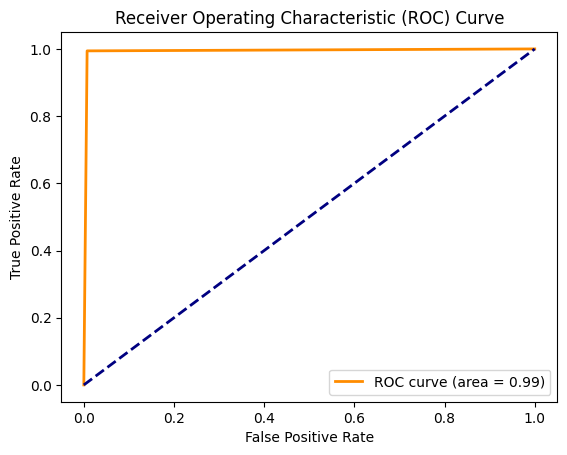

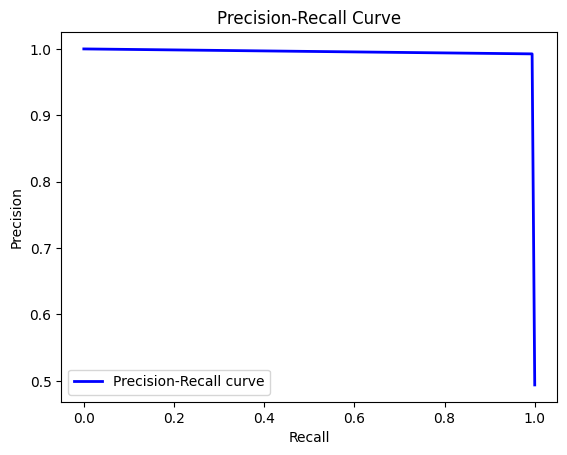

In [12]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, predictions)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [13]:
import numpy as np

# Self-implemented metrics calculation
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true).reshape(-1)
    y_pred = np.array(y_pred).reshape(-1)
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp) if (tp + fp) else 0
    recall = tp / (tp + fn) if (tp + fn) else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    support = len(y_true) #support - the number of true instances for each label. 
    
    return precision, recall, f1_score, support, accuracy

# Calculate metrics
precision, recall, f1_score, support, accuracy = calculate_metrics(y_test, predictions)

# Print classification metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")
print(f"Support: {support}")
print(f"Accuracy: {accuracy}")

Precision: 0.9925373134328358
Recall: 0.9941860465116279
F1-Score: 0.9933609958506224
Support: 2438
Accuracy: 0.9934372436423298
